# 0 Imports

In [58]:
import pandas as pd
import numpy as np
import inflection
import math
import datetime
import seaborn as sns

from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from scipy import stats  as ss
from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

## 0.1 Funções auxiliares

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [4]:
df_sales_raw = pd.read_csv('../inputs/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../inputs/store.csv', low_memory=False)

#join
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Renomeando colunas

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Dimensão dos dados

In [8]:
print('Núm de Linhas: {}'.format(df1.shape[0]))
print('Núm de Colunas: {}'.format(df1.shape[1]))

Núm de Linhas: 1017209
Núm de Colunas: 18


## 1.3 Tipo dos dados

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Checagem de valores nulos

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preenchimento de nulos

In [11]:
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [12]:
# competition_distance   
print(df1['competition_distance'].max())
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week           
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval              
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)        

75860.0


* Qual a lógica de atribuir a mesma data para as colunas com valores nulos?

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Mudando tipo dos dados

In [14]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Análise descritiva

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [16]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

In [17]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

### 1.7.1 Atributos númericos

In [18]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,6.0,0.001593,-1.246873
2,sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,0.641460,1.778375
3,customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7388.0,1.598650,7.091773
4,open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
5,promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,-7.235657,124.071304


<Figure size 2160x4320 with 0 Axes>

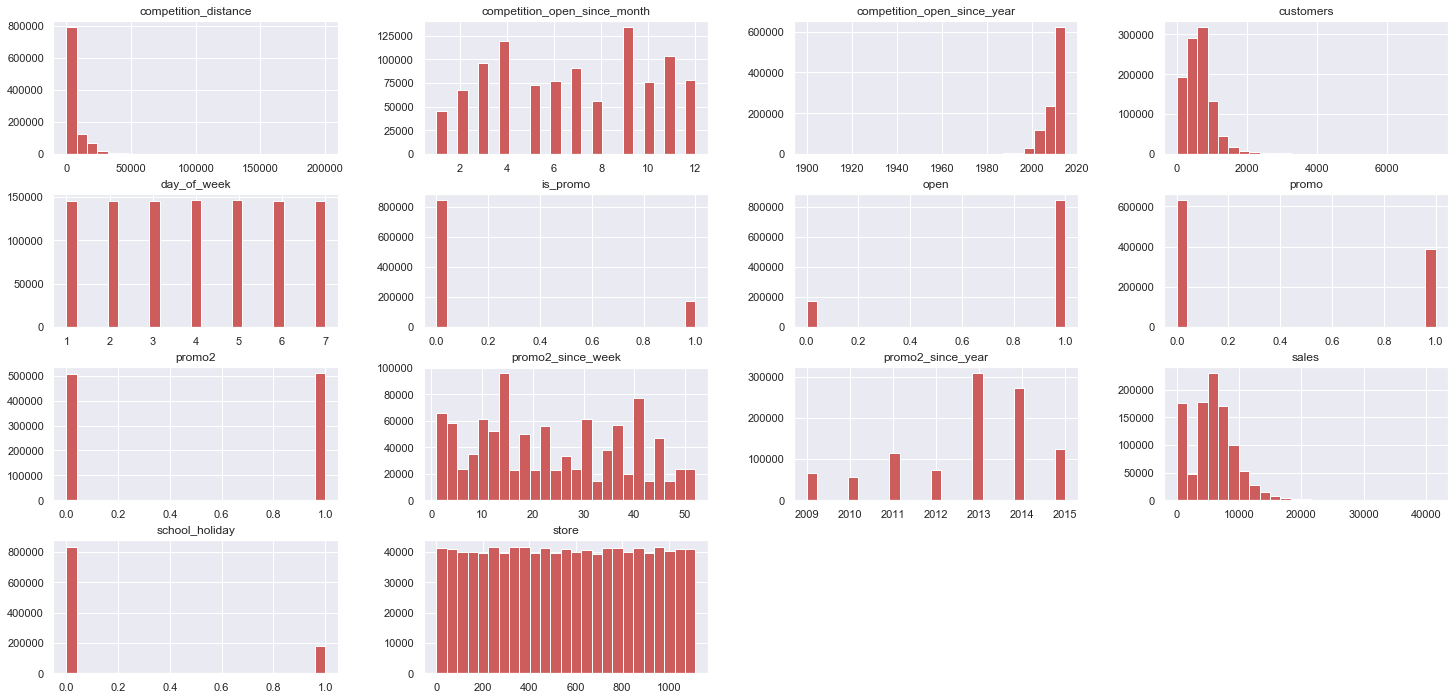

In [19]:
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

### 1.7.2 Atributos categóricos

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

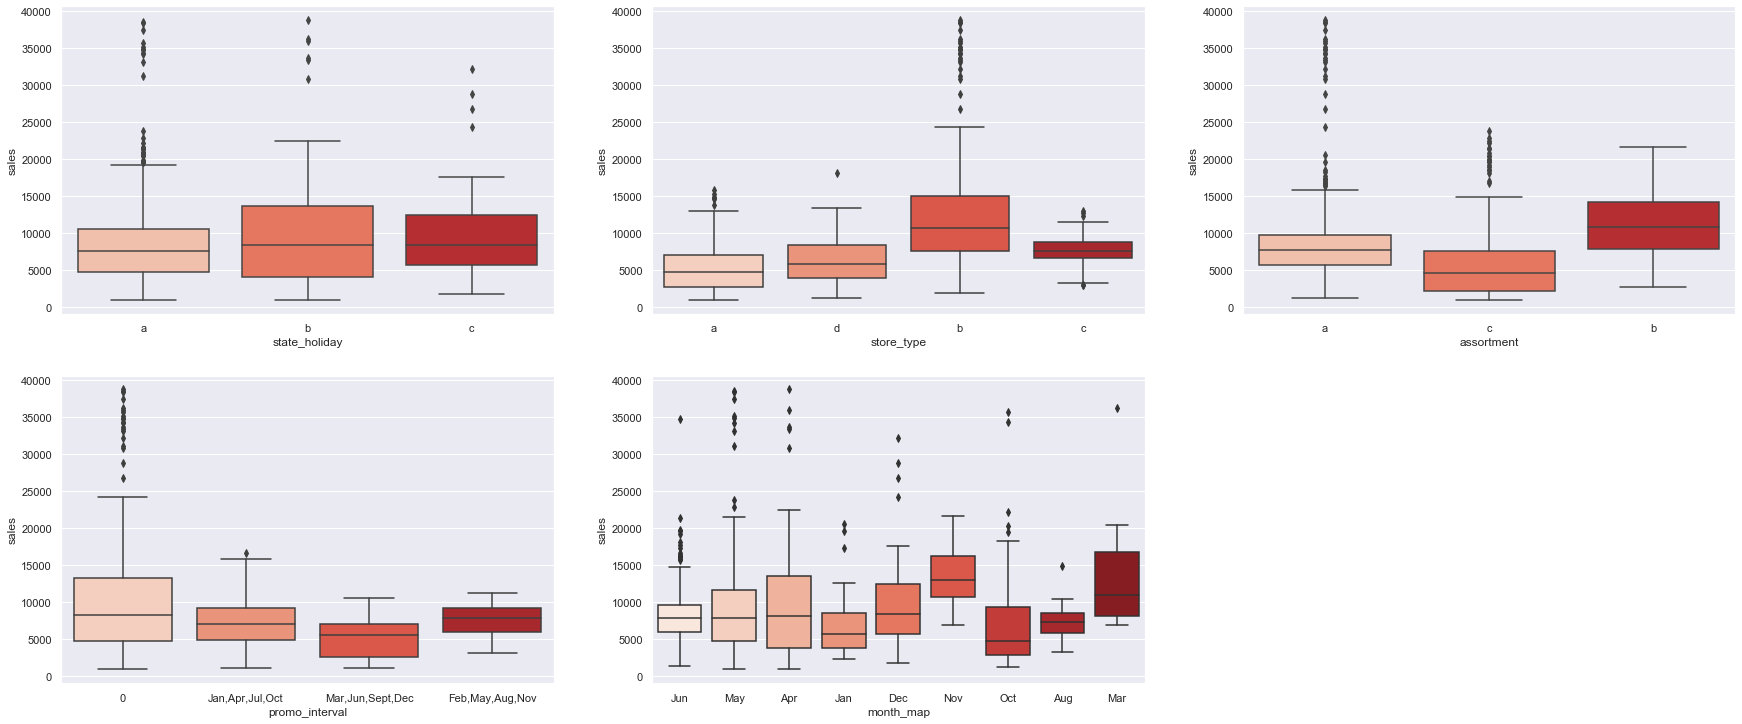

In [21]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize = (30,60))

x = 1
for d in cat_attributes:
    plt.subplot(9, 3, x)
    sns.boxplot( x=d, y='sales', data=aux, palette = 'Reds')
    x += 1


# 2 Feature engineering

In [22]:
df2 = df1.copy()

## 2.1 Mapa Mental de hipóteses

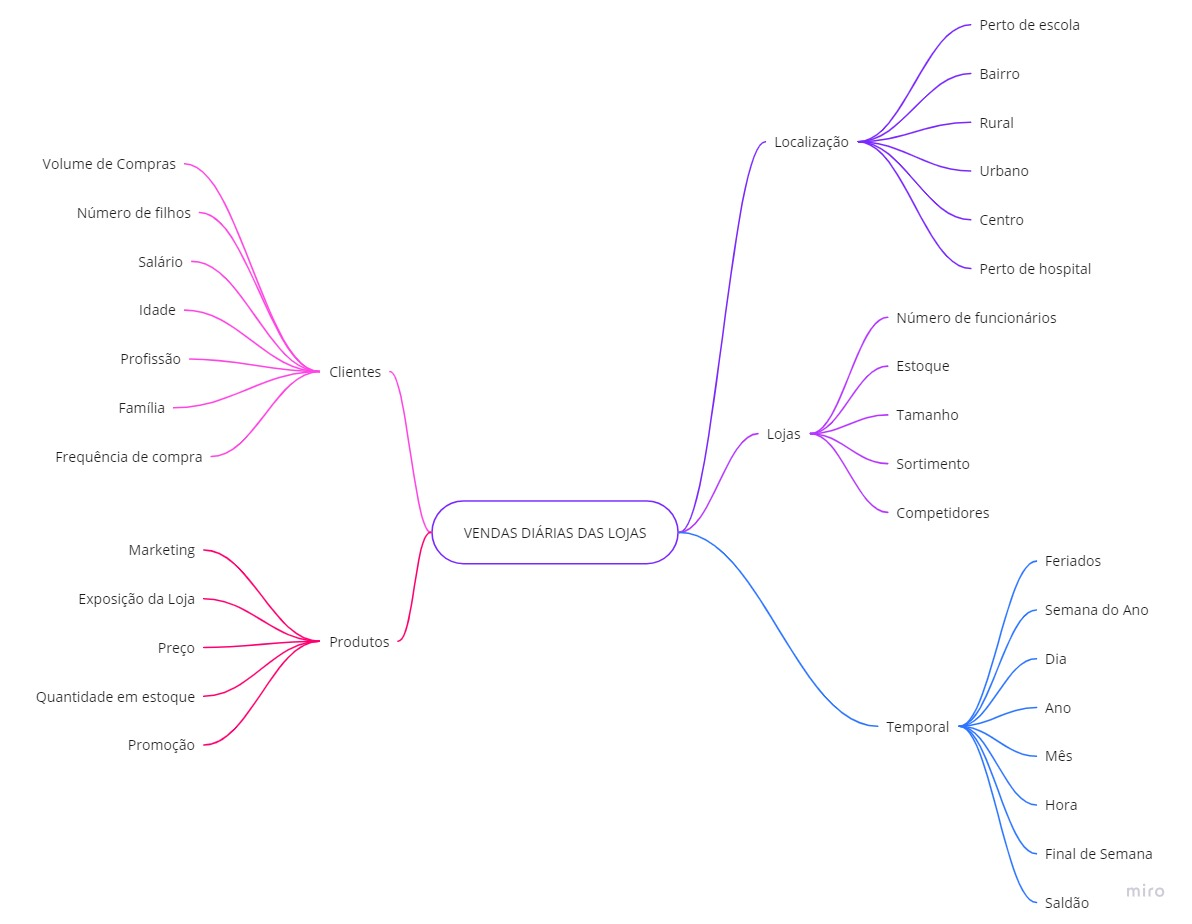

In [23]:
Image("../images/mind_map_rossmann.jpg")

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses das lojas

**1.** Lojas com número maior de funcionários vendem mais

**2.** Lojas com maior capacidade de estoque vendem mais

**3.** Lojas com maior porte vendem mais

**4.** Lojas com maior sortimentos vendem mais

**5.** Lojas com competidores mais próximos vendem menos

**6.** Lojas com competidores há mais tempo vendem mais

### 2.2.2 Hipóteses dos produtos

**1.** Lojas que investem mais em Marketing vendem mais

**2.** Lojas com maior exposição de produto vendem mais

**3.** Lojas com produtos com preço menor vendem mais

**4.** Lojas com promoções mais agressivas (descontos maiores) vendem mais

**5.** Lojas com promoções ativas por mais tempo vendem mais

**6.** Lojas com mais dias de promoção deveriam vendem mais

**7.** Lojas com mais promoções consecutivas vendem mais

### 2.2.3 Hipóteses temporais

**1.** Lojas abertas durante o feriado de Natal vendem mais

**2.** Lojas vendem mais ao longo dos anos

**3.** Lojas vendem mais no segundo semestre do ano

**4.** Lojas vendem mais depois do dia 10 de cada mês

**5.** Lojas vendem menos aos finais de semana

**6.** Lojas vendem menos durante os feriados escolares

## 2.3 Lista final de hipóteses

**1.** Lojas com maior sortimentos vendem mais

**2.** Lojas com competidores mais próximos vendem menos

**3.** Lojas com competidores há mais tempo vendem mais

**4.** Lojas com promoções ativas por mais tempo vendem mais

**5.** Lojas com mais dias de promoção deveriam vendem mais

**6.** Lojas com mais promoções consecutivas vendem mais

**7.** Lojas abertas durante o feriado de Natal vendem mais

**8.** Lojas vendem mais ao longo dos anos

**9.** Lojas vendem mais no segundo semestre do ano

**10.** Lojas vendem mais depois do dia 10 de cada mês

**11.** Lojas vendem menos aos finais de semana

**12.** Lojas vendem menos durante os feriados escolares

## 2.4 Criação de novas variáveis

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis= 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype('str')
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days= 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3 Filtragem dos dados

In [26]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem das colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis= 1)

# 4. Análise exploratória de dados (EDA)

In [29]:
df4 = df3.copy()

In [30]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise univariada

### 4.1.1 Variável resposta

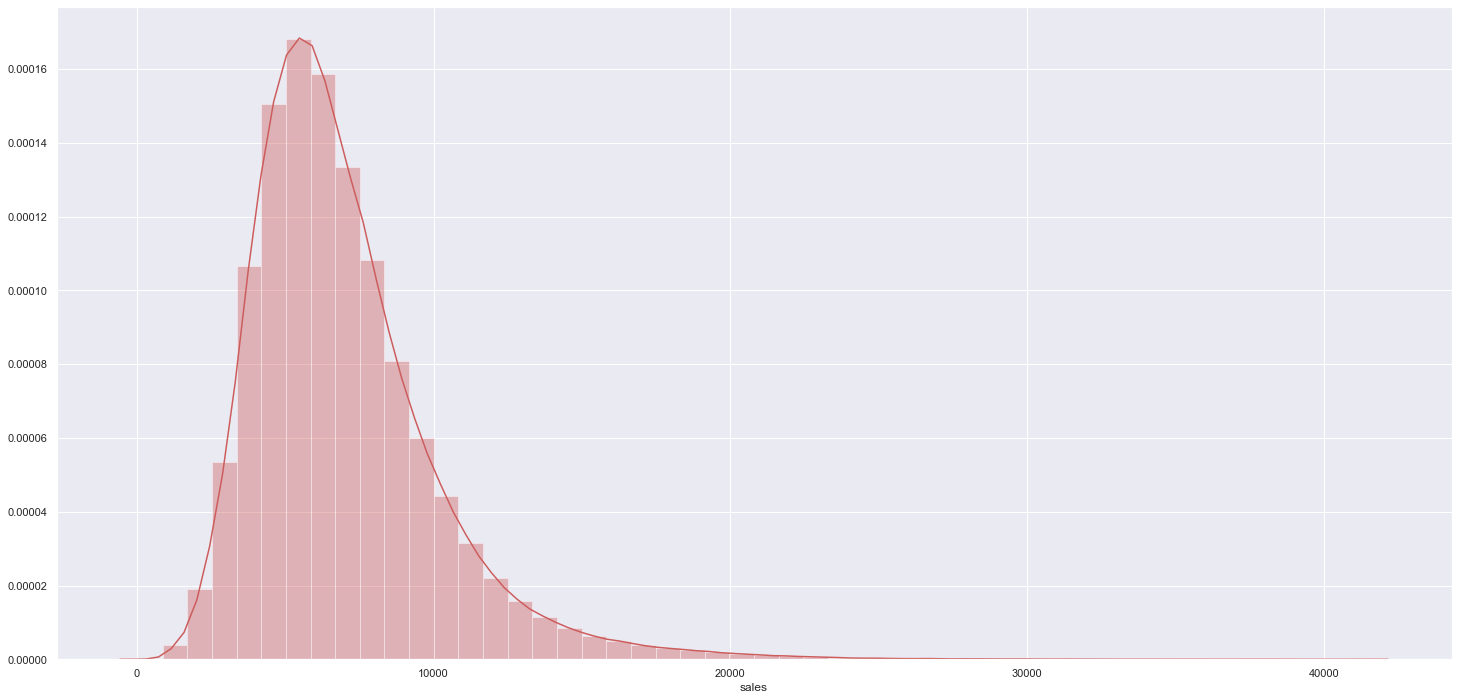

In [31]:
sns.distplot(df4['sales'], color='indianred');

### 4.1.2 Variáveis numéricas

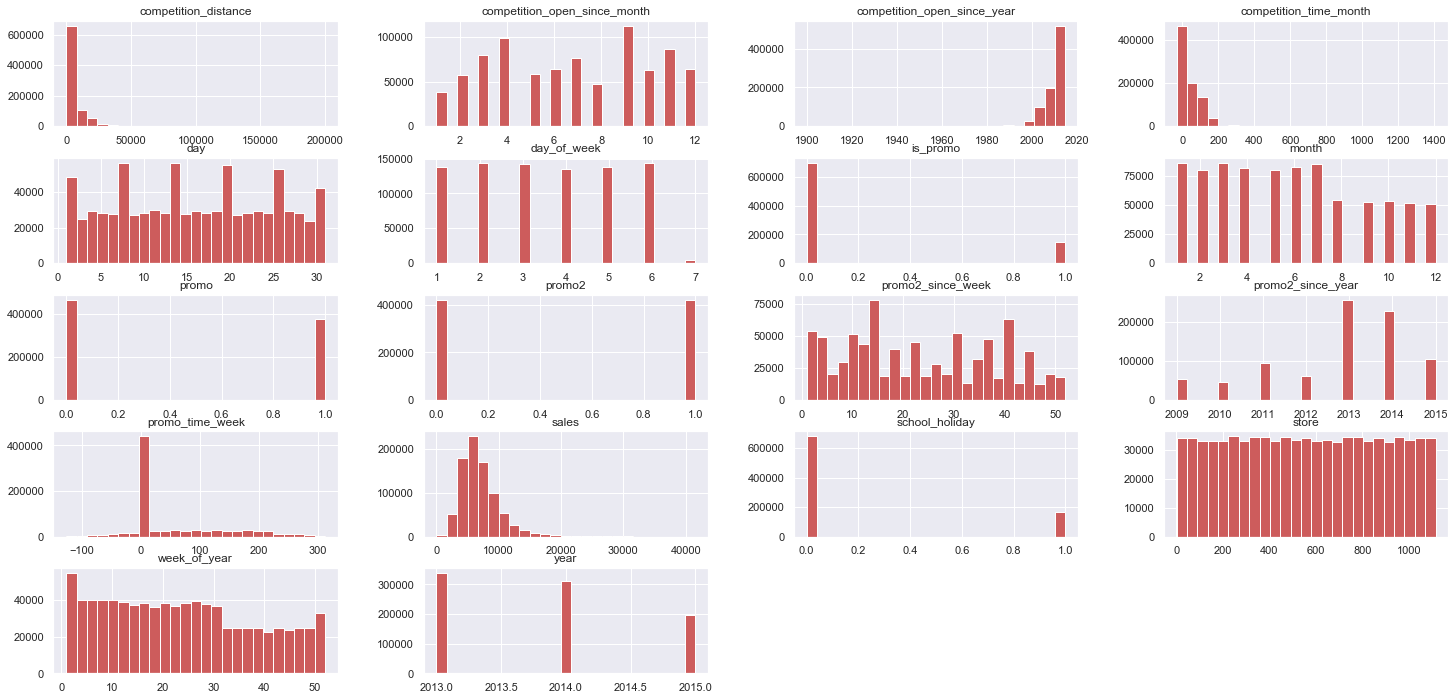

In [32]:
num_attributes.hist(color='indianred', bins=25);

### 4.1.3 Variável categóricas

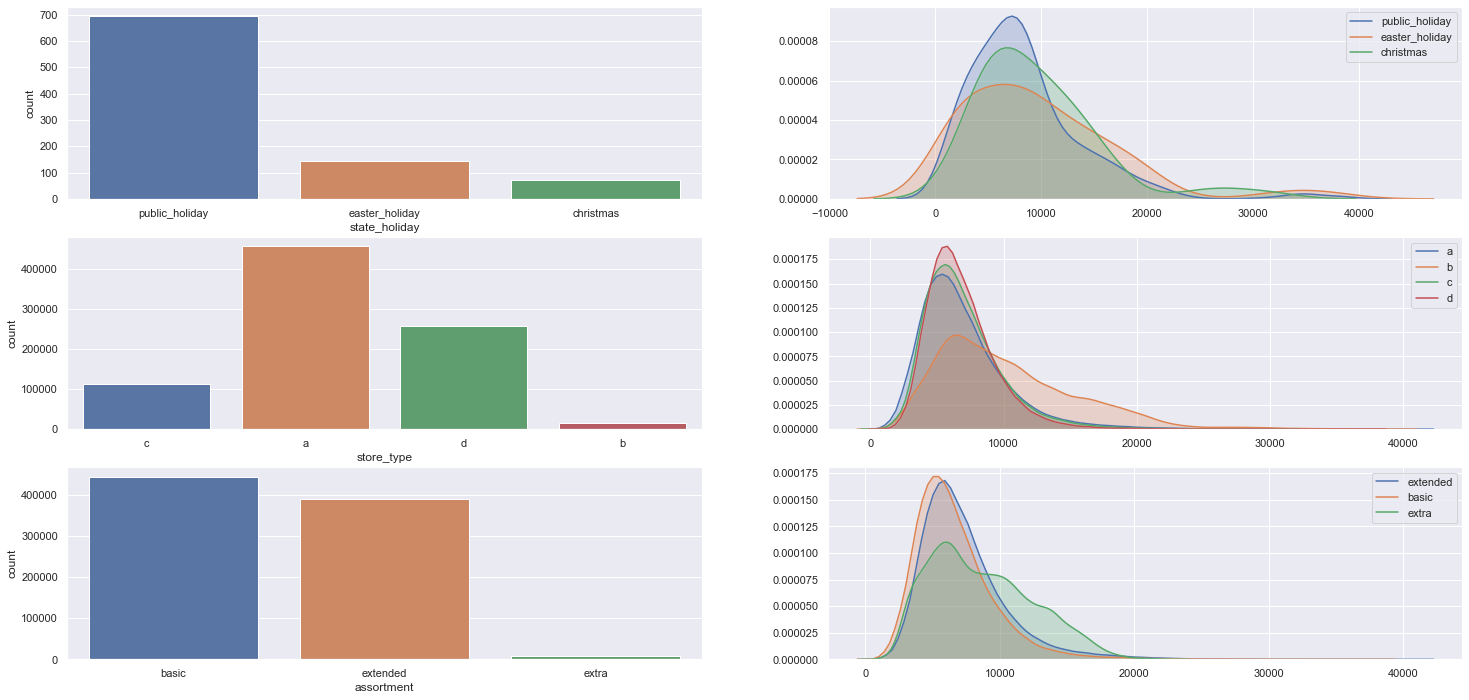

In [33]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Análise bivariada

### H1: Lojas com maior sortimentos vendem mais
**FALSA** Lojas com maior sortimento vendem menos

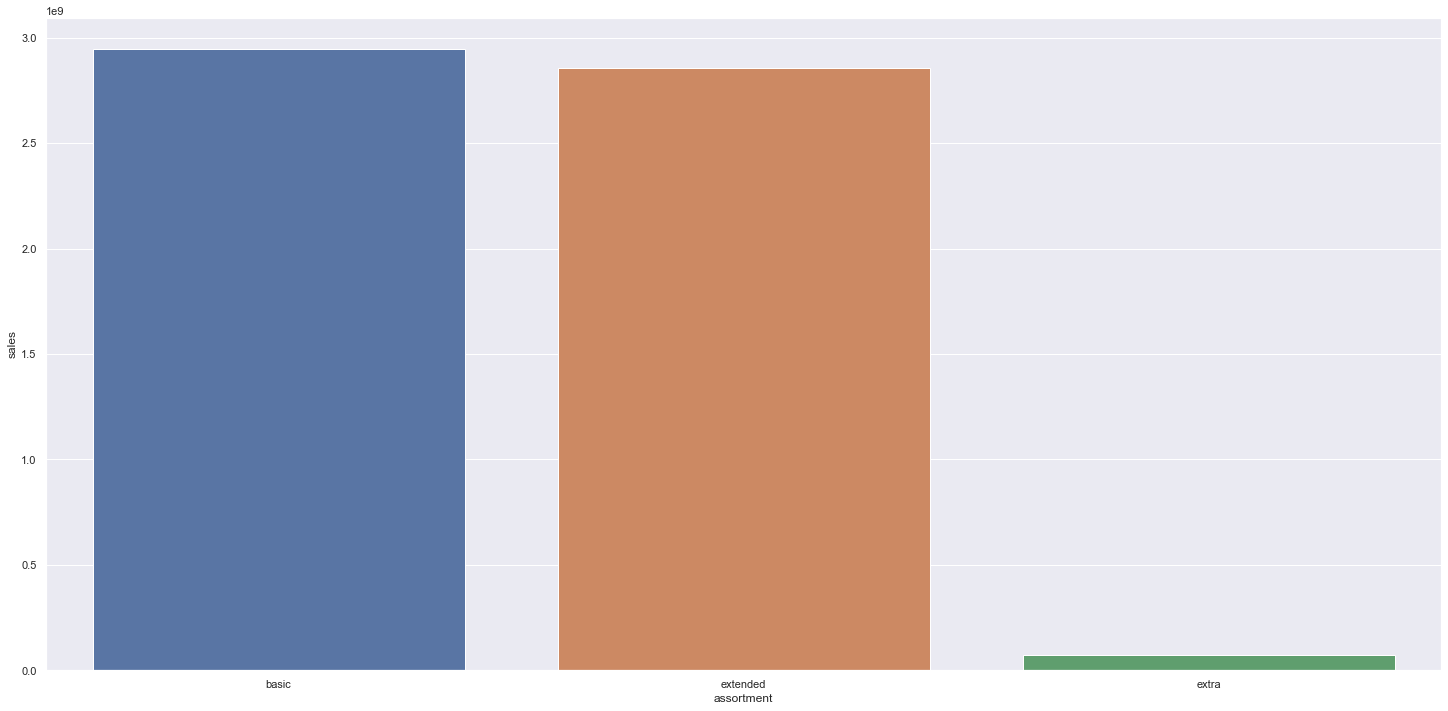

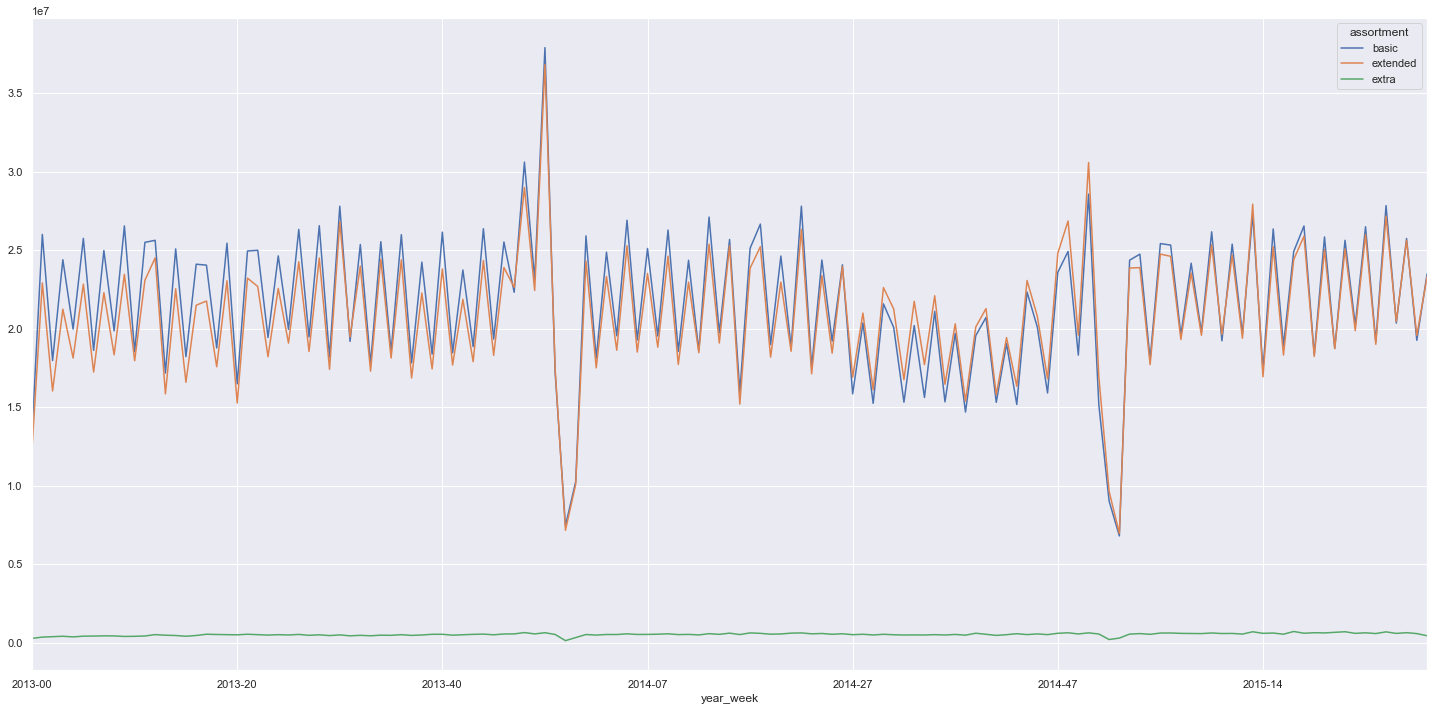

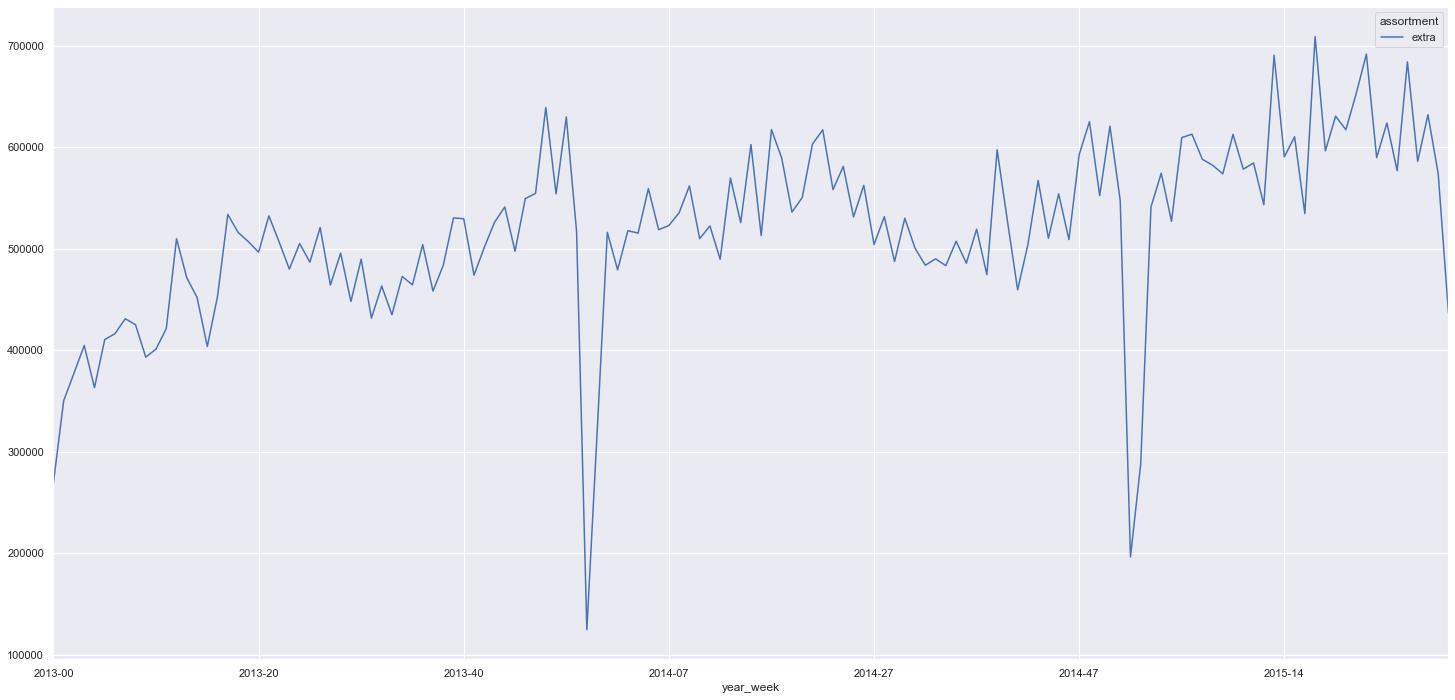

In [34]:
aux1 = df4.groupby('assortment')['sales'].sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4.groupby(['year_week','assortment'])['sales'].sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2: Lojas com competidores mais próximos vendem menos
**FALSA** Lojas com competidores mais próximos vendem mais

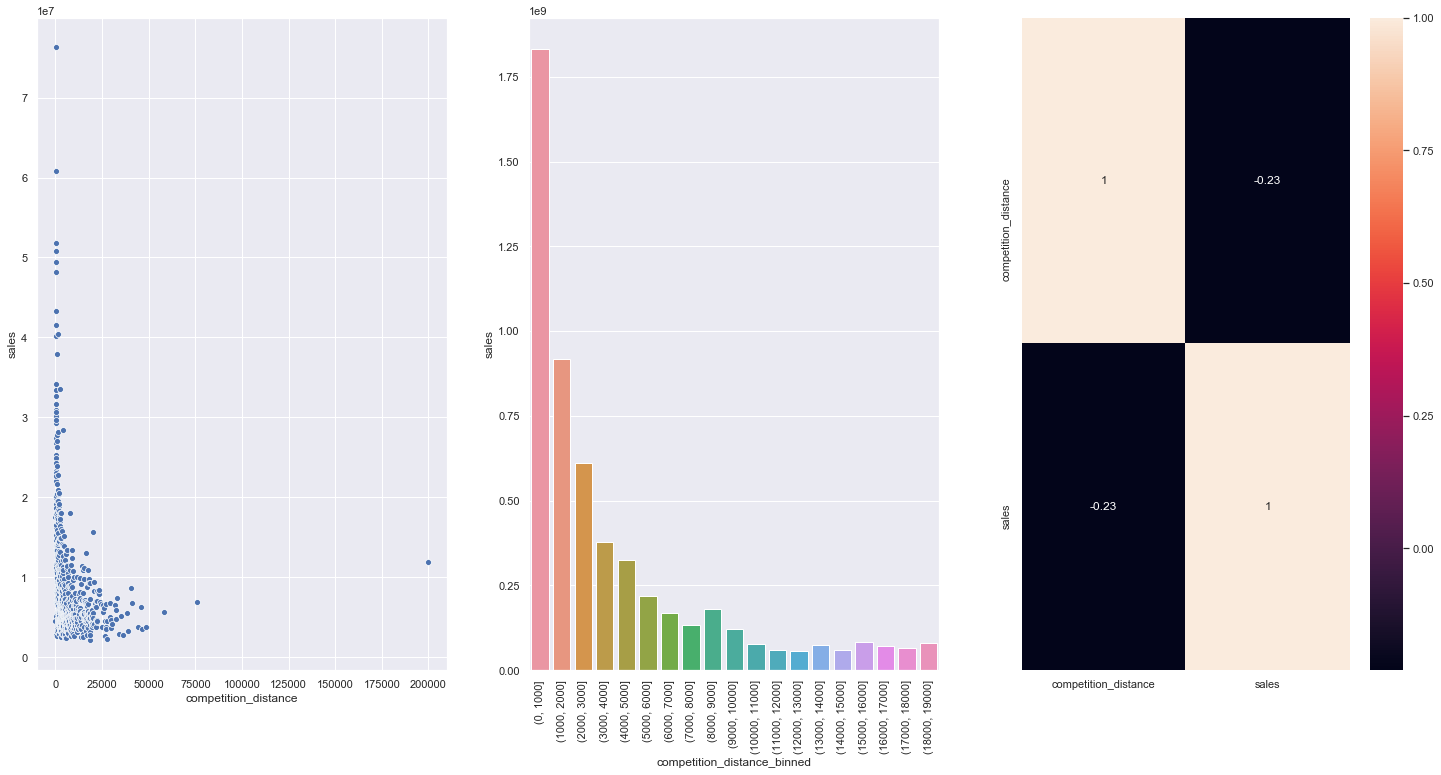

In [35]:
aux1 = df4.groupby('competition_distance')['sales'].sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1.groupby( 'competition_distance_binned' )['sales'].sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3: Lojas com competidores há mais tempo vendem mais
**FALSE** Lojas com competidores há mais tempo vendem menos

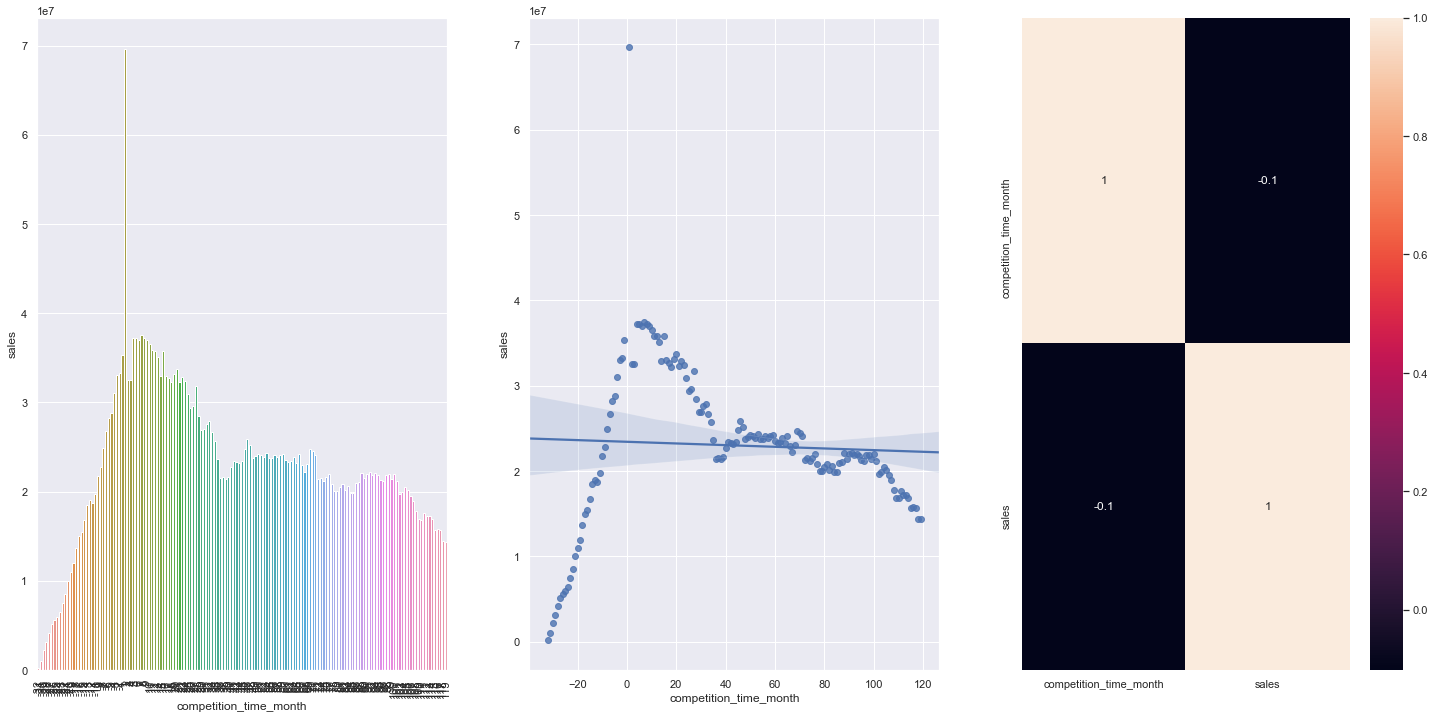

In [36]:
plt.subplot( 1, 3, 1 )
aux1 = df4.groupby('competition_time_month')['sales'].sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4: Lojas com promoções ativas por mais tempo vendem mais
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

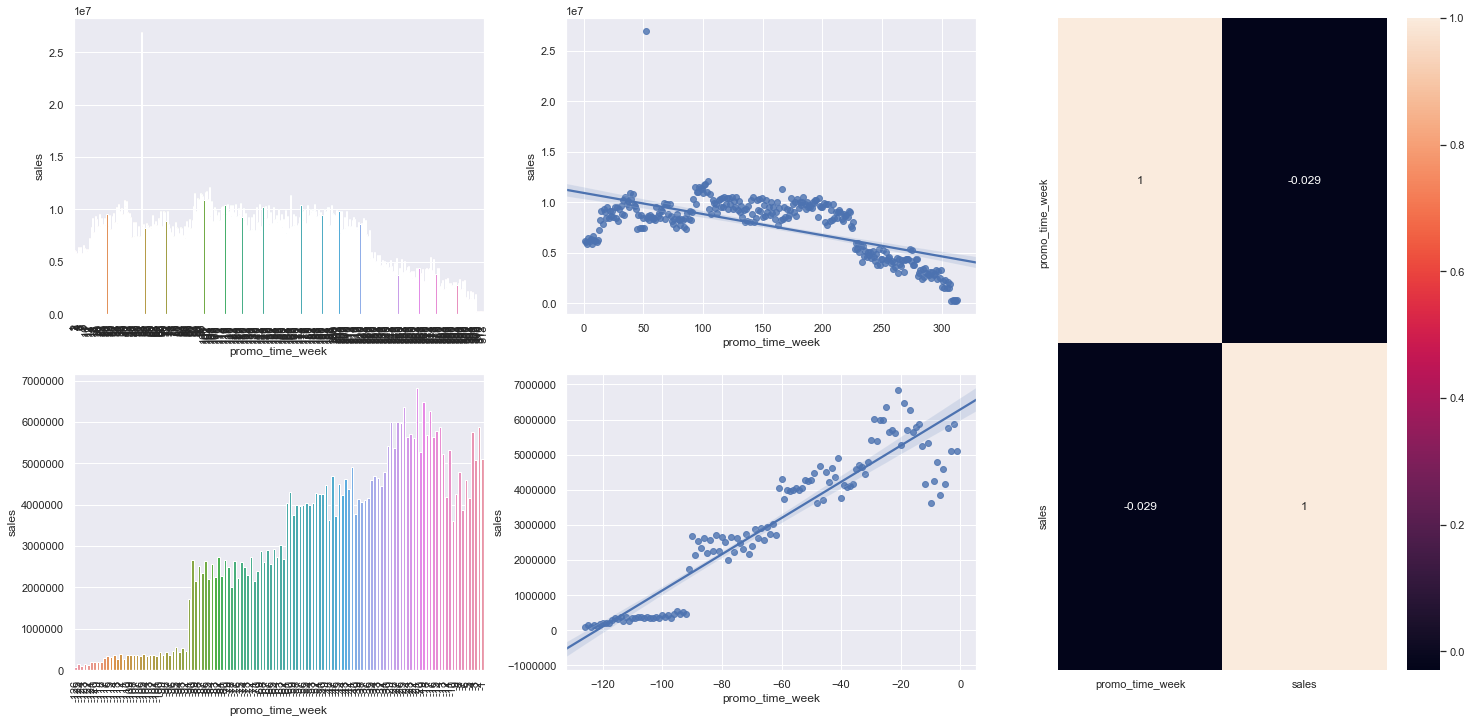

In [37]:
aux1 = df4.groupby('promo_time_week')['sales'].sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5: Lojas com mais dias de promoção deveriam vendem mais <s/>

### H6: Lojas com mais promoções consecutivas vendem mais
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [38]:
df4.groupby(['promo', 'promo2'])['sales'].sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


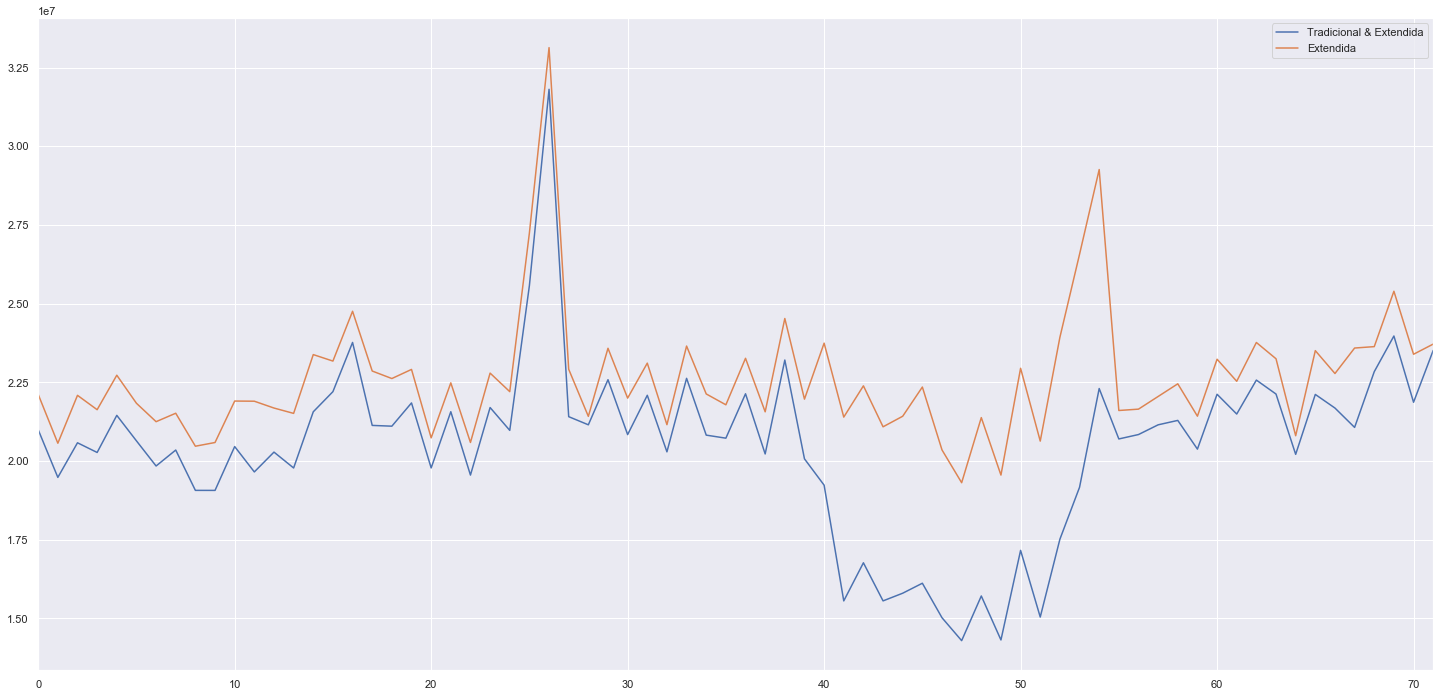

In [39]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)].groupby( 'year_week' )['sales'].sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)].groupby( 'year_week' )['sales'].sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7: Lojas abertas durante o feriado de Natal vendem mais
**FALSA** Lojas abertas durante o feriado do Natal vendem menos

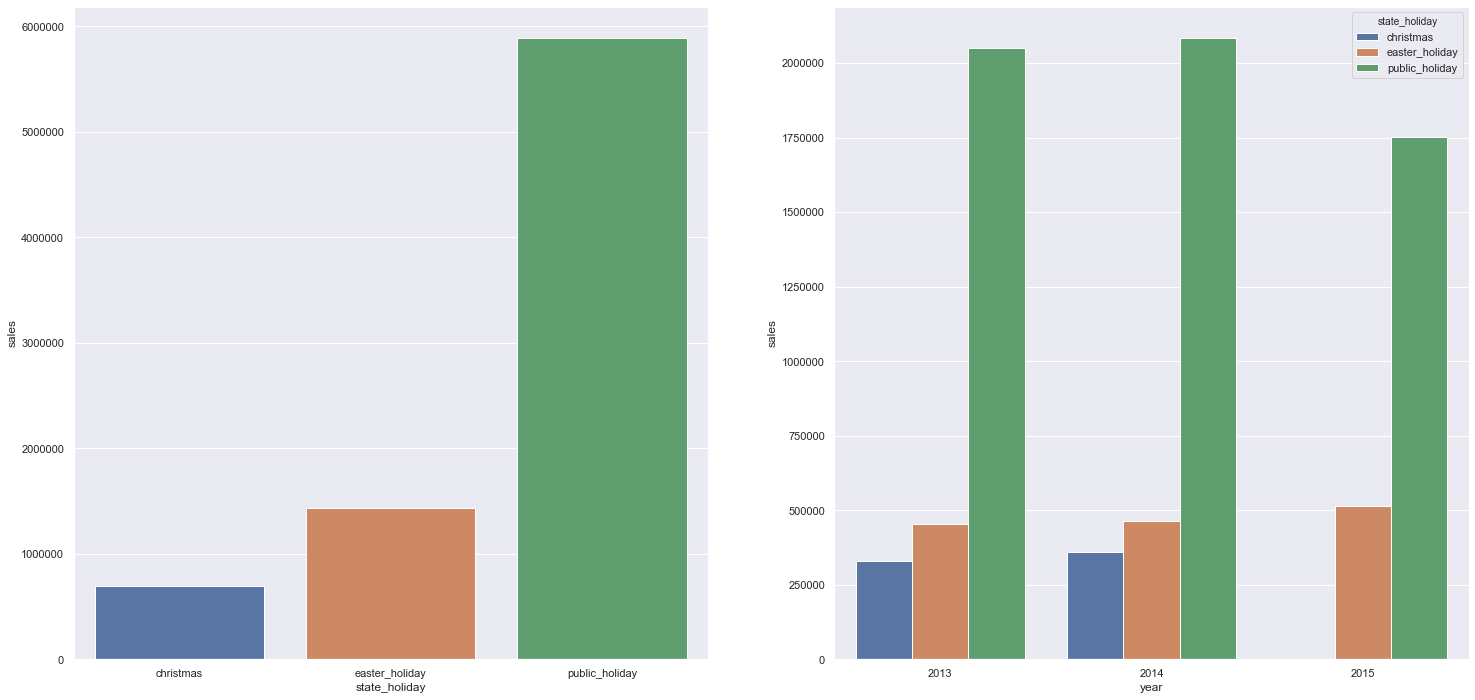

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux.groupby('state_holiday')['sales'].sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux.groupby(['year', 'state_holiday'])['sales'].sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8: Lojas vendem mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

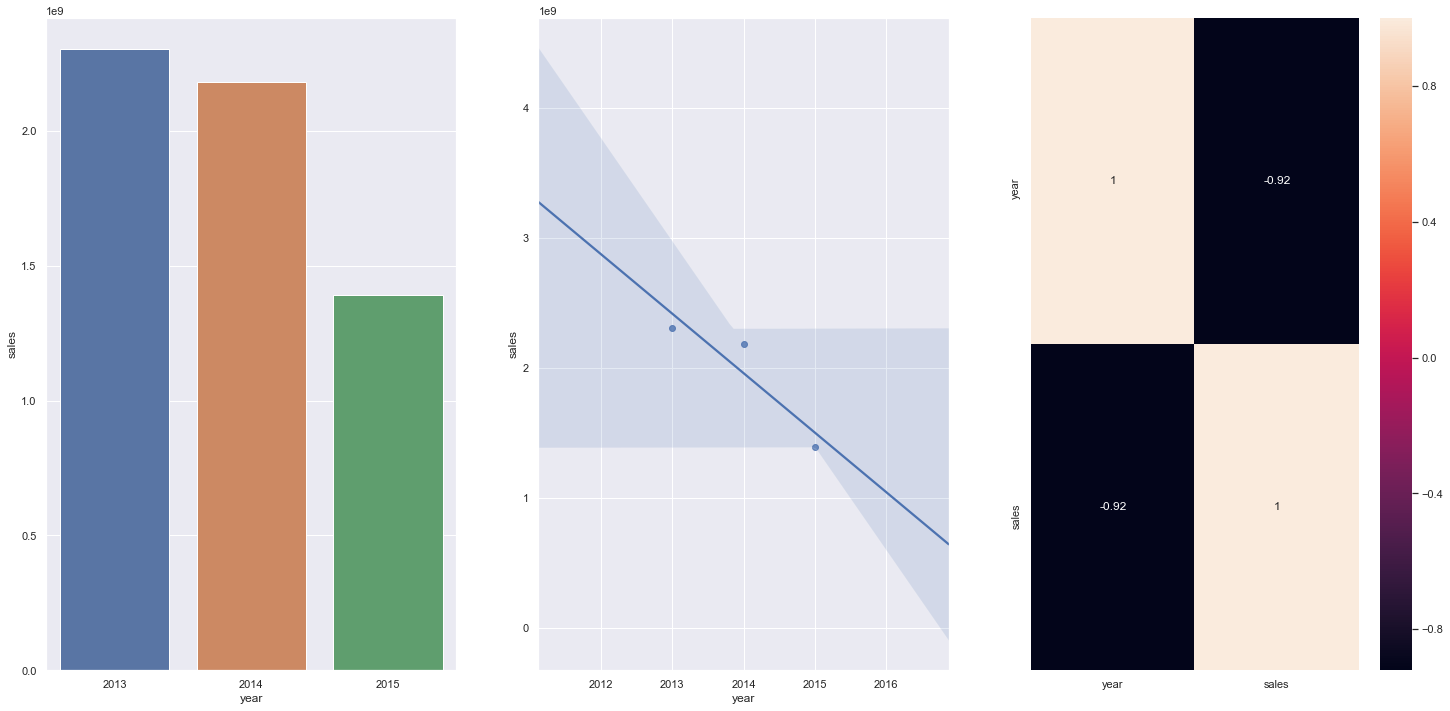

In [41]:
aux1 = df4.groupby('year')['sales'].sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9: Lojas vendem mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

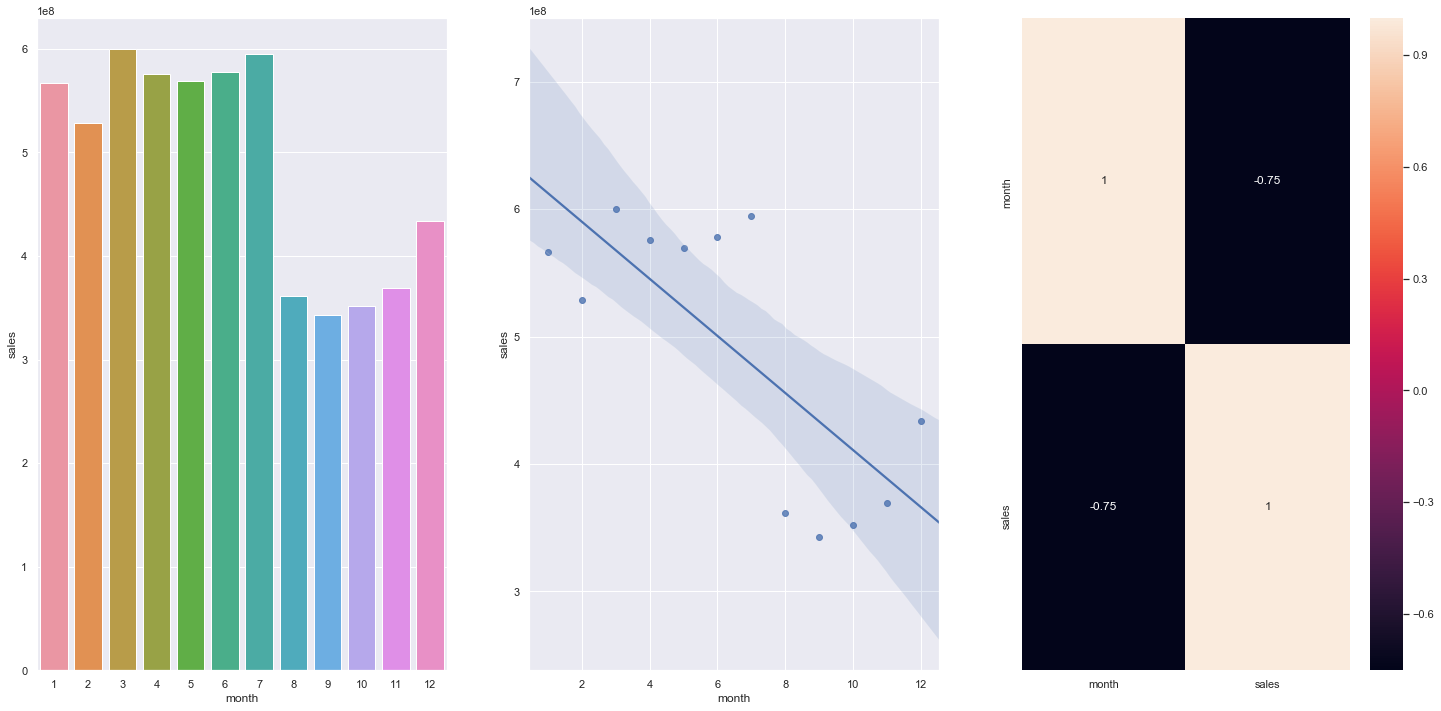

In [42]:
aux1 = df4.groupby('month')['sales'].sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10: Lojas vendem mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes

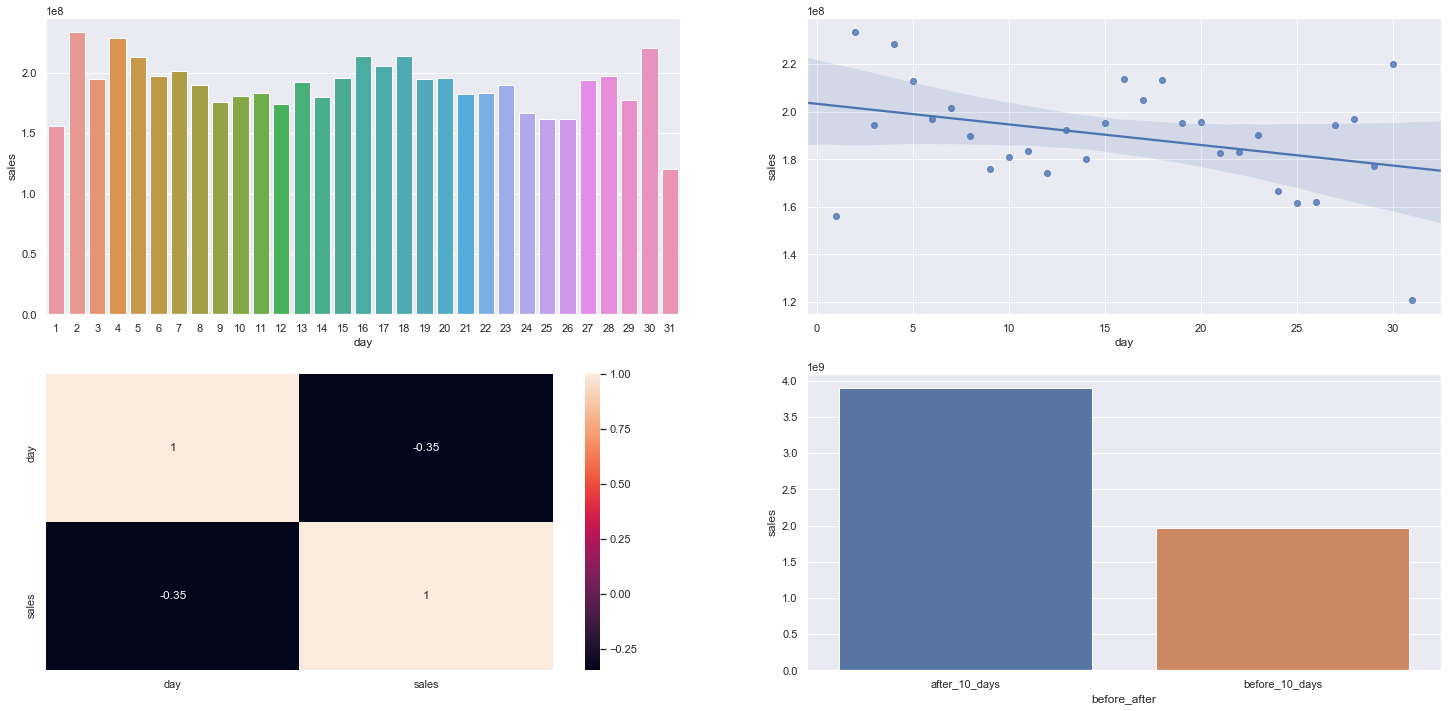

In [43]:
aux1 = df4.groupby( 'day' )['sales'].sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 =aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11: Lojas vendem menos aos finais de semana
**VERDADEIRA** Lojas vendem menos nos final de semana

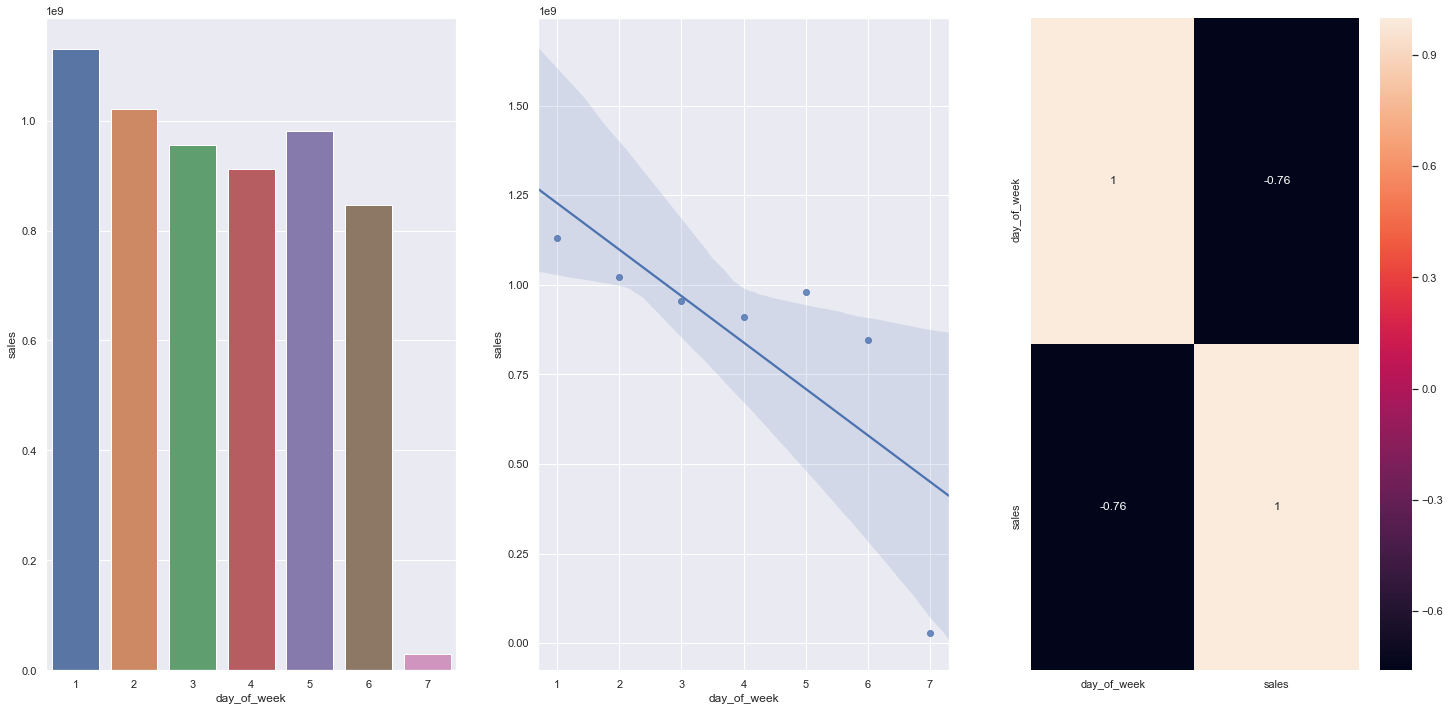

In [44]:
aux1 = df4.groupby( 'day_of_week' )['sales'].sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12: Lojas vendem menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos meses de Julho e Agosto

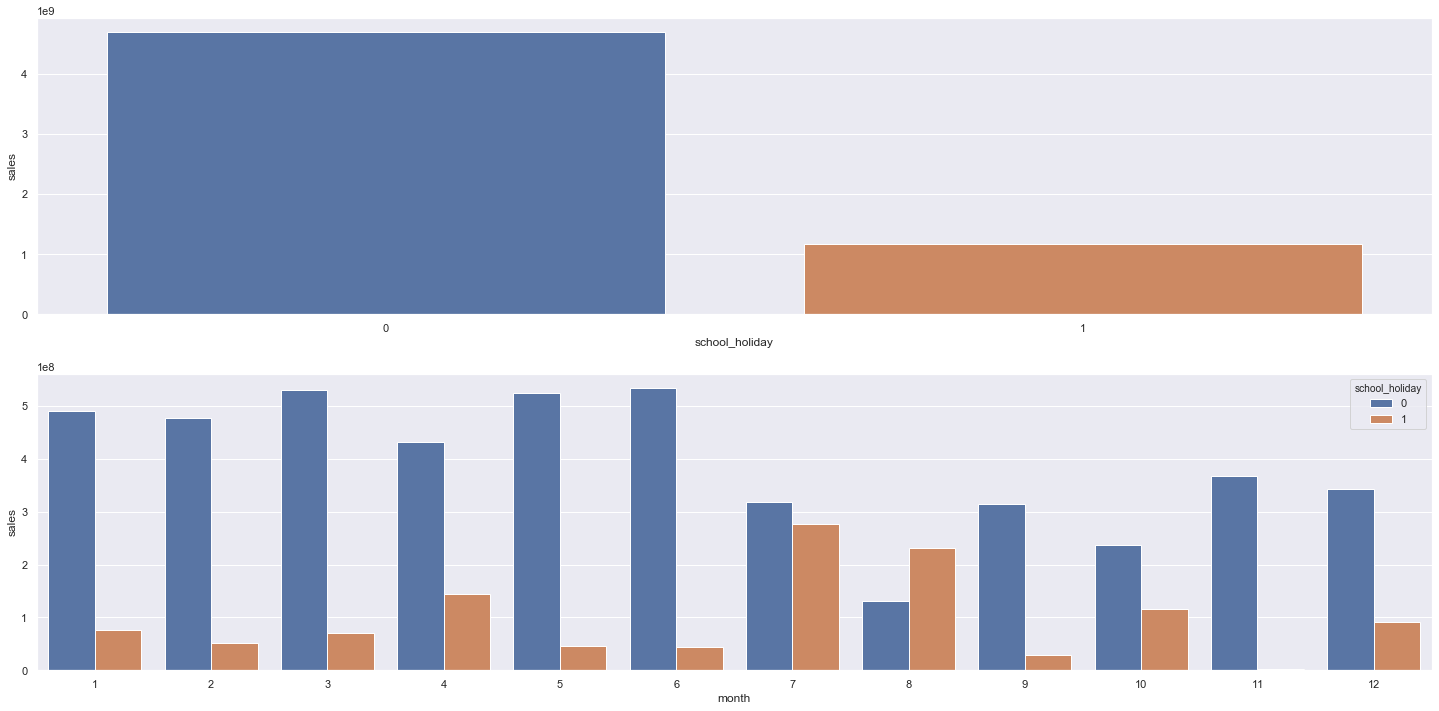

In [45]:
aux1 = df4.groupby('school_holiday')['sales'].sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4.groupby(['month','school_holiday'])['sales'].sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das hipóteses

In [46]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print(tabulate( tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise multivariada

### 4.3.1 Variáveis númericas

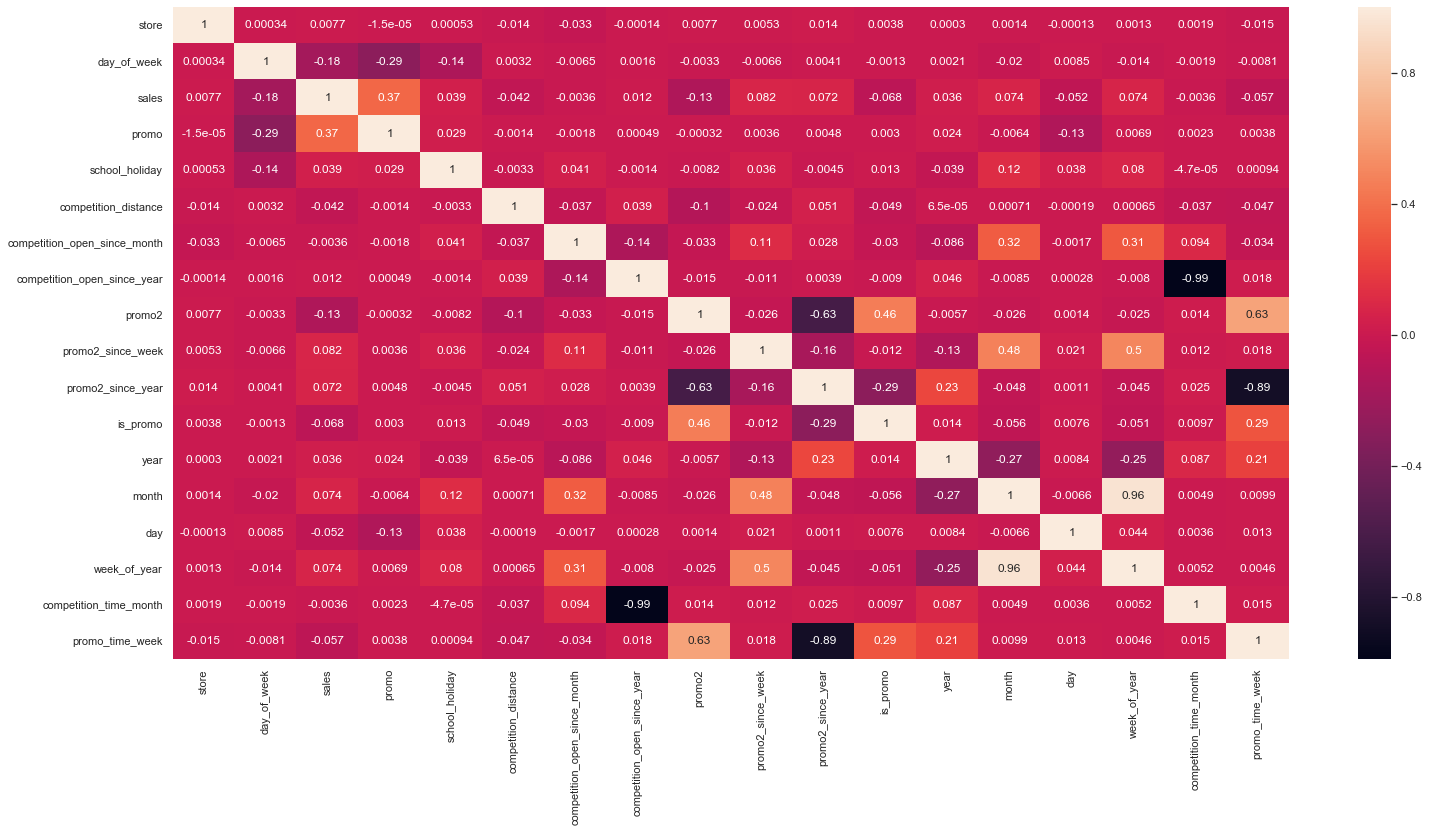

In [47]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Variáveis categóricas

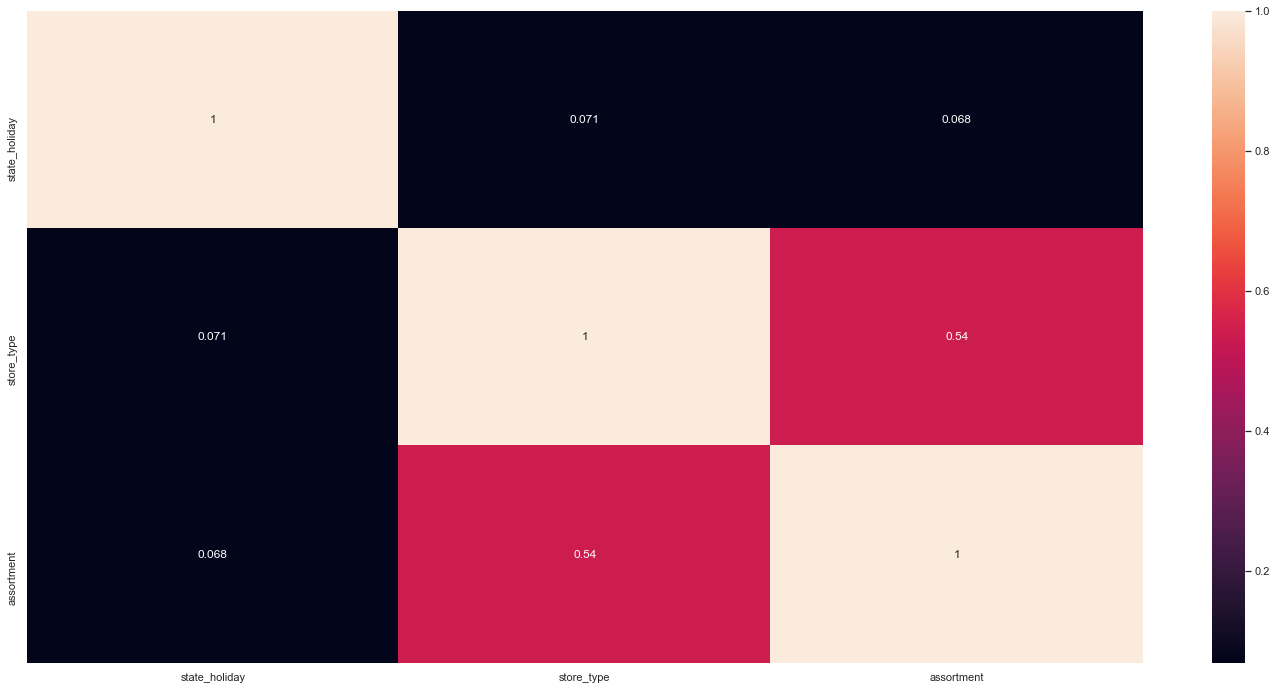

In [48]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]
                 })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5 Preparação dos dados

In [49]:
df5 = df4.copy()

## 5.1 Normalização

Nenhuma das variáveis númericas segue a distribuição normal

## 5.2 Rescaling

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [51]:
# state_holiday - One hot enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da variável resposta

In [52]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de natureza

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6 Seleção de variáveis

In [54]:
df6 = df5.copy()

## 6.1 Separação do conjunto de dados em treino e teste

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis= 1)

In [56]:
# dataset de treino
X_train = df6[df6['date'] < '2015-06-19'] # - 6 semanas do final do dataset
y_train = X_train['sales']

# dataset de teste 
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test ['sales']

print('Training Min Date: {}'.format( X_train['date'].min()))
print('Training Max Date: {}'.format( X_train['date'].max()))

print('\nTest Min Date: {}'.format( X_test['date'].min()))
print('Test Max Date: {}'.format( X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta como feature selector
Tempo de execução 1h15

In [60]:
# # treino e teste datasets para o Boruta
# X_train_n = X_train.drop(['sales', 'date'], axis= 1).values
# y_train_n = y_train.values.ravel()

# # definindo o estimador de RandomForest
# rf = RandomForestRegressor(n_jobs= -1)

# # definindo o Boruta
# boruta = BorutaPy(rf, n_estimators= 'auto', verbose= 2, random_state= 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Melhores variáveis pelo Boruta

In [62]:
# cols_selected = boruta.support_.tolist()

# # melhores variáveis
# X_train_fs = X_train.drop(['date', 'sales'], axis= 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # variáveis não selecionadas
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

Compararado com as variáveis que foram julgadas com alta relevância na EDA

## 6.3 Seleção de variáveis manual após Boruta

In [64]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin', #add
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin', #add
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )